In [557]:
import os
from collections import namedtuple, defaultdict
import xml.etree.ElementTree as ET
from shapely.geometry import MultiPolygon, Point, Polygon
import numpy as np
from threading import local, get_ident
from time import time
import random

In [558]:
_Slide=namedtuple('_Slide', ['slide_path', 'mask_path', 'xml_tissue', 'xml_cancer'])
_PolygonRaw = namedtuple('_Polygon', ['slide_path', 'coord'])
_Polygon=namedtuple('_Polygon', ['slide_path', 'area', 'polygon'])
_Data=namedtuple('_Data', ['slide_path', 'mask_path', 'coord', 'whiteness'])

In [559]:
def get_files(folder_with_data):
    slides_path=folder_with_data+'slides/'
    masks_path=folder_with_data+'masks/'
    xmls_path=folder_with_data+'annotations/'
    for name in os.listdir(slides_path):
        yield _Slide(slides_path+name, 
                     masks_path+name.split('.')[0]+'_M.tif', 
                     xmls_path+name.split('.')[0]+'_G.xml',
                     xmls_path+name.split('.')[0]+'.xml')

In [560]:
def get_coordinate(_list, cancer=True):
    for el in _list:
        if cancer:
            xml_file = el.xml_cancer
        else:
            xml_file=el.xml_tissue
        for ann in ET.parse(xml_file).getroot().find('Annotations'):
            yx=[(int(float(coord.attrib['Y'])), int(float(coord.attrib['X']))) for coord in ann.find('Coordinates').findall('Coordinate')]
            yield _PolygonRaw(el.slide_path, yx)

In [561]:
def clear_small_polygon(_list):
    for el in _list:
        p=Polygon(el.coord)
        area=p.area
        if area > 1024*1024:
            yield _Polygon(el.slide_path, area, p)

In [562]:
def get_dict(source_files, cancer=True):
    d=defaultdict(list)
    for path, area, poly in clear_small_polygon(get_coordinate(source_files, cancer=cancer)):
        d[path].append((area, poly))
    return d

In [563]:
def to_multi(_list):
    return MultiPolygon([[p.exterior.coords, []] for _, p in _list]).buffer(0)

In [832]:
def subtraction(cancer, tissue):
    for k in (set(cancer) & set(tissue)):
        gt = tissue[k]
        canc = cancer[k]
        mp = to_multi(canc)
        tmp = ((poly.buffer(5) - mp) for _, poly in gt)
        tissue[k] = [(p.area, p) for p in tmp]
    return (cancer, tissue)

In [833]:
_TLS = local()
def tls_prng():
    # pylint: disable=no-member
    try:
        return _TLS.prng
    except AttributeError:
        _TLS.prng = np.random.RandomState(
            (get_ident() + np.random.get_state()[1][0]) % 2**32
        )
        return _TLS.prng

In [834]:
def get_random_points(polygon, number):
    prng = tls_prng()

    if not polygon.area:
        return

    minx, miny, maxx, maxy = polygon.bounds
    for _ in range(number):
        while True:
            p = Point(prng.uniform(minx, maxx), prng.uniform(miny, maxy))
            if polygon.contains(p):
                yield (int(p.coords[0][0]), int(p.coords[0][1]))
                break

In [835]:
files=list(get_files('../data/'))
cancer=get_dict(files, cancer=True)
tissue=get_dict(files, cancer=False)
cancer, tissue=subtraction(cancer, tissue)

In [996]:
# _Data=namedtuple('_Data', ['slide_path', 'mask_path', 'coord', 'whiteness'])

In [838]:
rnd_point=list(get_random_points(cancer['../data/slides/32.tif'][2][1], 100))

In [839]:
r=rnd_point

In [840]:
print(r)
i=0

[(81878, 35479), (76483, 40990), (76680, 39279), (74765, 40948), (80709, 34496), (84468, 37072), (84119, 37838), (78378, 31728), (80293, 39678), (86673, 33753), (73748, 39493), (79253, 37144), (85803, 34714), (81252, 36645), (74422, 39047), (83102, 35218), (74699, 36997), (78040, 39917), (86390, 35540), (72128, 40797), (83720, 31349), (82482, 33423), (81969, 29075), (79950, 33395), (80448, 38258), (76569, 40456), (77106, 30760), (84484, 35001), (76532, 38953), (84014, 36275), (82329, 34971), (87487, 35095), (72175, 41166), (85891, 30120), (83168, 37635), (86724, 33642), (78698, 38688), (78916, 34743), (83792, 32552), (77400, 36395), (78137, 36832), (77019, 32427), (76347, 35533), (84613, 31491), (80381, 35881), (81005, 37406), (84349, 34946), (81197, 33694), (79440, 38996), (78842, 34214), (79602, 31940), (87319, 34470), (84525, 36169), (72020, 40381), (79578, 31512), (81818, 34073), (83026, 31352), (79565, 34488), (77832, 36254), (85898, 32854), (80808, 34486), (76426, 36054), (84072,

In [1088]:
import sys
from skimage.io import imshow
from PIL import Image
patch_size=(512,512)
zoom=2
i+=1
if 'D:\\ACDC_LUNG_HISTOPATHOLOGY\\ASAP 1.9\\bin' not in sys.path:
    sys.path.append('D:\\ACDC_LUNG_HISTOPATHOLOGY\\ASAP 1.9\\bin')
import multiresolutionimageinterface as mir
reader = mir.MultiResolutionImageReader()

mask = reader.open('../data/masks/50A_M.tif')
slide =reader.open('../data/slides/50A.tif')
mask_patch=mask.getUCharPatch(startY=140386, startX=32869, height=patch_size[0], width=patch_size[1], level=zoom)
slide_patch=slide.getUCharPatch(startY=140386, startX=32869, height=patch_size[0], width=patch_size[1], level=zoom)

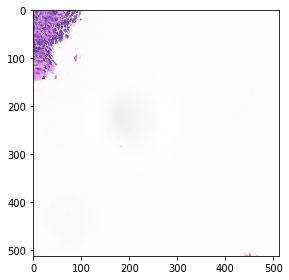

In [1089]:
imshow(slide_patch)

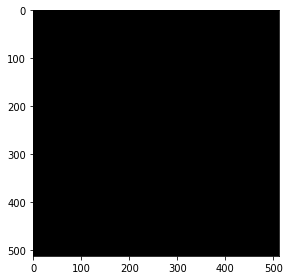

In [1090]:
imshow(mask_patch[:,:,0]*255)

In [1149]:
_Data=namedtuple('_Data', ['slide_path', 'mask_path', 'coord', 'whiteness'])
nbpoints=2
patch_size=(512,512)
zoom=1


def get_data_unsafe(cancer, tissue, patch_size, zoom, nbpoints):
    np.random.seed(int(time() * 1000) % 2**32)
    reader = mir.MultiResolutionImageReader()
    for _ in range(nbpoints):
        rnd_cancer_slide=random.choice(list(cancer.keys()))
        rnd_tissue_slide=random.choice(list(tissue.keys()))

        rnd_cancer_poly=random.choice(cancer[rnd_cancer_slide])[1]
        rnd_tissue_poly=random.choice(tissue[rnd_tissue_slide])[1]

        rnd_cancer_point=list(get_random_points(rnd_cancer_poly, 1))
        rnd_tissue_point=list(get_random_points(rnd_tissue_poly, 1))

        for path, yx in zip((rnd_cancer_slide, rnd_tissue_slide), rnd_cancer_point+rnd_tissue_point):
            mask_path=path.replace('slides', 'masks').replace('.tif','_M.tif')
            mask=reader.open(mask_path)
            mask_patch=mask.getUCharPatch(startY=yx[0], startX=yx[1], height=patch_size[0], width=patch_size[1], level=zoom)
            mask.close()
            mask_patch=mask_patch[:,:,0]*255
            mask_patch=mask_patch.astype(bool)
            values, counts = np.unique(mask_patch, return_counts=True)
            yield _Data(path, mask_path, yx, sum(values * counts) / sum(counts) * 100)

In [1163]:
data=list(get_data_unsafe(cancer, tissue, patch_size, zoom, 100))

In [1164]:
data

[_Data(slide_path='../data/slides/9A.tif', mask_path='../data/masks/9A_M.tif', coord=(73269, 41749), whiteness=78.39279174804688),
 _Data(slide_path='../data/slides/16.tif', mask_path='../data/masks/16_M.tif', coord=(62332, 40956), whiteness=1.446533203125),
 _Data(slide_path='../data/slides/22A.tif', mask_path='../data/masks/22A_M.tif', coord=(87229, 51492), whiteness=11.719131469726562),
 _Data(slide_path='../data/slides/5A.tif', mask_path='../data/masks/5A_M.tif', coord=(145876, 11523), whiteness=98.66485595703125),
 _Data(slide_path='../data/slides/18A.tif', mask_path='../data/masks/18A_M.tif', coord=(105321, 45383), whiteness=59.25941467285156),
 _Data(slide_path='../data/slides/48A.tif', mask_path='../data/masks/48A_M.tif', coord=(137310, 50595), whiteness=34.27276611328125),
 _Data(slide_path='../data/slides/34.tif', mask_path='../data/masks/34_M.tif', coord=(22040, 61754), whiteness=6.5143585205078125),
 _Data(slide_path='../data/slides/49A.tif', mask_path='../data/masks/49A_M.

In [1167]:
indexes = sorted(data, key=lambda item: item.whiteness)

In [1185]:
_TLS = local()


def tls_prng():
    # pylint: disable=no-member
    try:
        return _TLS.prng
    except AttributeError:
        _TLS.prng = np.random.RandomState(
            (get_ident() + np.random.get_state()[1][0]) % 2**32
        )
        return _TLS.prng

In [1206]:
prng = tls_prng()
minx, miny, maxx, maxy = cancer['../data/slides/32.tif'][1][1].bounds
p = Point(prng.uniform(minx, maxx)-patch_size[0]*2**zoom, prng.uniform(miny, maxy)-patch_size[0]*2**zoom)

In [1208]:
sorted(data, key=lambda item: item.whiteness)

[_Data(slide_path='../data/slides/34.tif', mask_path='../data/masks/34_M.tif', coord=(41510, 41807), whiteness=0.0),
 _Data(slide_path='../data/slides/4A.tif', mask_path='../data/masks/4A_M.tif', coord=(73166, 49379), whiteness=0.0),
 _Data(slide_path='../data/slides/34A.tif', mask_path='../data/masks/34A_M.tif', coord=(58243, 19683), whiteness=0.0),
 _Data(slide_path='../data/slides/25A.tif', mask_path='../data/masks/25A_M.tif', coord=(98256, 24059), whiteness=0.0),
 _Data(slide_path='../data/slides/45.tif', mask_path='../data/masks/45_M.tif', coord=(76048, 36963), whiteness=0.0),
 _Data(slide_path='../data/slides/47A.tif', mask_path='../data/masks/47A_M.tif', coord=(51497, 19247), whiteness=0.0),
 _Data(slide_path='../data/slides/59.tif', mask_path='../data/masks/59_M.tif', coord=(19732, 40775), whiteness=0.0),
 _Data(slide_path='../data/slides/62.tif', mask_path='../data/masks/62_M.tif', coord=(128212, 41073), whiteness=0.0),
 _Data(slide_path='../data/slides/98.tif', mask_path='../

In [1202]:
# [el for el in data if el.whiteness==0.0 or el.whiteness>90.0]

In [1205]:
type(cancer)

collections.defaultdict